In [2]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import tables

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack

from traitlets.config.loader import Config
from ctapipe_io_lst import LSTEventSource
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters

from lstchain.io.config import read_configuration_file
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_lstcam_key, dl1_params_src_dep_lstcam_key

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.io.eventseeker import EventSeeker
#import astropy.units as u
#from copy import deepcopy

from scipy.stats import binned_statistic

from ImageExtracterConfig import ImageExtracterConfig

In [3]:
from logging import getLogger,StreamHandler,DEBUG,INFO,WARNING,ERROR,CRITICAL

##### Logger #####
logger = getLogger(__name__)
handler = StreamHandler()
loglevel = 'INFO'
handler.setLevel(loglevel)
logger.setLevel(loglevel)
logger.addHandler(handler)

In [4]:
from lstchain import __version__ as lstchain_version
logger.info(lstchain_version)

0.7.3.post19+gitdeabb5c


In [5]:
# Matplotlib setup
plt.rcParams["font.size"] = 13

LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
MARKER_STYLES = ['o', 's', 'x', '+', 'D', 'X', 'p', 'd', '<', '>', '^', 'v', 'H']

plt.xkcd()

# Config of ImageExtracter

In [6]:
# Replace OUTPUT_DIR_PATH by your directory
OUTPUT_DIR_PATH = Path('/home/mitsunari.takahashi/Work/analysis/low-level/ChargeExtraction_test')
if not OUTPUT_DIR_PATH.exists():
    os.makedirs(OUTPUT_DIR_PATH)

## List of confugurations to evaluate  

In [7]:
image_extracter_configs = []

# LocalPeakWindowSum
for window_width in (5,):
    window_shift = int(window_width/2)
    image_extracter_configs.append(ImageExtracterConfig('LocalPeakWindowSum', 
                                                        {'window_shift':window_shift,
                                                         'window_width':window_width,
                                                         'apply_integration_correction':'true'}, 
                                                       output_dir_path=OUTPUT_DIR_PATH, 
                                                       config_dir_path=OUTPUT_DIR_PATH))
    
# NeighborPeakWindowSum
for window_width in (5,):
    window_shift = int(window_width/2)
    for lwt in (0, ):#1):
        image_extracter_configs.append(ImageExtracterConfig('NeighborPeakWindowSum', 
                                                            {'window_shift':window_shift, 
                                                             'window_width':window_width,
                                                             'lwt':lwt,
                                                             'apply_integration_correction':'true'}, 
                                                       output_dir_path=OUTPUT_DIR_PATH, 
                                                       config_dir_path=OUTPUT_DIR_PATH))
        
# SlidingWindowMaxSum
for window_width in (5,):
    image_extracter_configs.append(ImageExtracterConfig('SlidingWindowMaxSum', 
                                                        {'window_width':window_width,
                                                         'apply_integration_correction':'true'}, 
                                                       output_dir_path=OUTPUT_DIR_PATH, 
                                                       config_dir_path=OUTPUT_DIR_PATH))

# TwoPassWindowSum
for core_threshold in (6,):
    image_extracter_configs.append(ImageExtracterConfig('TwoPassWindowSum', 
                                                        {'core_threshold':core_threshold, 
                                                         'disable_second_pass':'false',
                                                         'apply_integration_correction':'true'}, 
                                                       output_dir_path=OUTPUT_DIR_PATH, 
                                                       config_dir_path=OUTPUT_DIR_PATH))
    
# FullWaveformSum
image_extracter_configs.append(ImageExtracterConfig('FullWaveformSum', 
                                                    output_dir_path=OUTPUT_DIR_PATH, 
                                                    config_dir_path=OUTPUT_DIR_PATH))

# Write the config files down         
for c in image_extracter_configs:
    c.write_configfile()

# MC DL0 data

In [8]:
dl0_path = Path('/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/4LSTs_MAGIC/gamma-diffuse/zenith_20deg/south_pointing/run1000/sim_telarray_v3_trans_80%/cta-prod5-lapalma_4LSTs_MAGIC/0.0deg/Data/gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')
#dl0_path = Path('/fefs/aswg/data/mc/DL0/20200629_prod5/gamma-diffuse/zenith_20deg/south_pointing/gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')

In [9]:
tel_id = 1 #LST-1
allowed_tels = {tel_id}
source = EventSource(dl0_path)
source.allowed_tels = allowed_tels

In [10]:
counter = 0
true_phe = []
true_log10_phe = []

for event in source:
    event_id = event.index.event_id
    true_image = event.simulation.tel[tel_id].true_image
    for trimg in true_image:
        true_phe.append(trimg)
        true_log10_phe.append(np.log10(max(0.1,trimg)))
    counter+=1
logger.debug(counter)      

In [11]:
true_phe = np.array(true_phe)
true_log10_phe = np.array(true_log10_phe)

# DL1 data

In [12]:
for image_extracter_config in image_extracter_configs:
    logger.info(image_extracter_config.config_name)
    dl1_production_result = image_extracter_config.produce_mc_dl1(dl0_path=dl0_path)
    if dl1_production_result!=0:
        logger.error('Producing DL1 file failed!!')

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue
/home/mitsunari.takahashi/Work/analysis/low-level/ChargeExtraction_test/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue/dl1_gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.h5 already exists! It was modified 23 hr 54 min before.
NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue
/home/mitsunari.takahashi/Work/analysis/low-level/ChargeExtraction_test/NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue/dl1_gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.h5 already exists! It was modified 23 hr 51 min before.
SlidingWindowMaxSum_window_width5_apply_integration_correctiontrue
/home/mitsunari.takahashi/Work/analysis/low-level/ChargeExtraction_test/SlidingWindowMaxSum_window_width5_apply_integration_correctiontrue/dl1_gamma_20deg_180deg_run10

## DL1 Data Readout

In [13]:
for image_extracter_config in image_extracter_configs:
    image_extracter_config.read_dl1()

In [14]:
for image_extracter_config in image_extracter_configs:
    image_extracter_config.calc_correlations(true_phe)

# Plot

/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/home/mitsunari.takahashi/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encounter

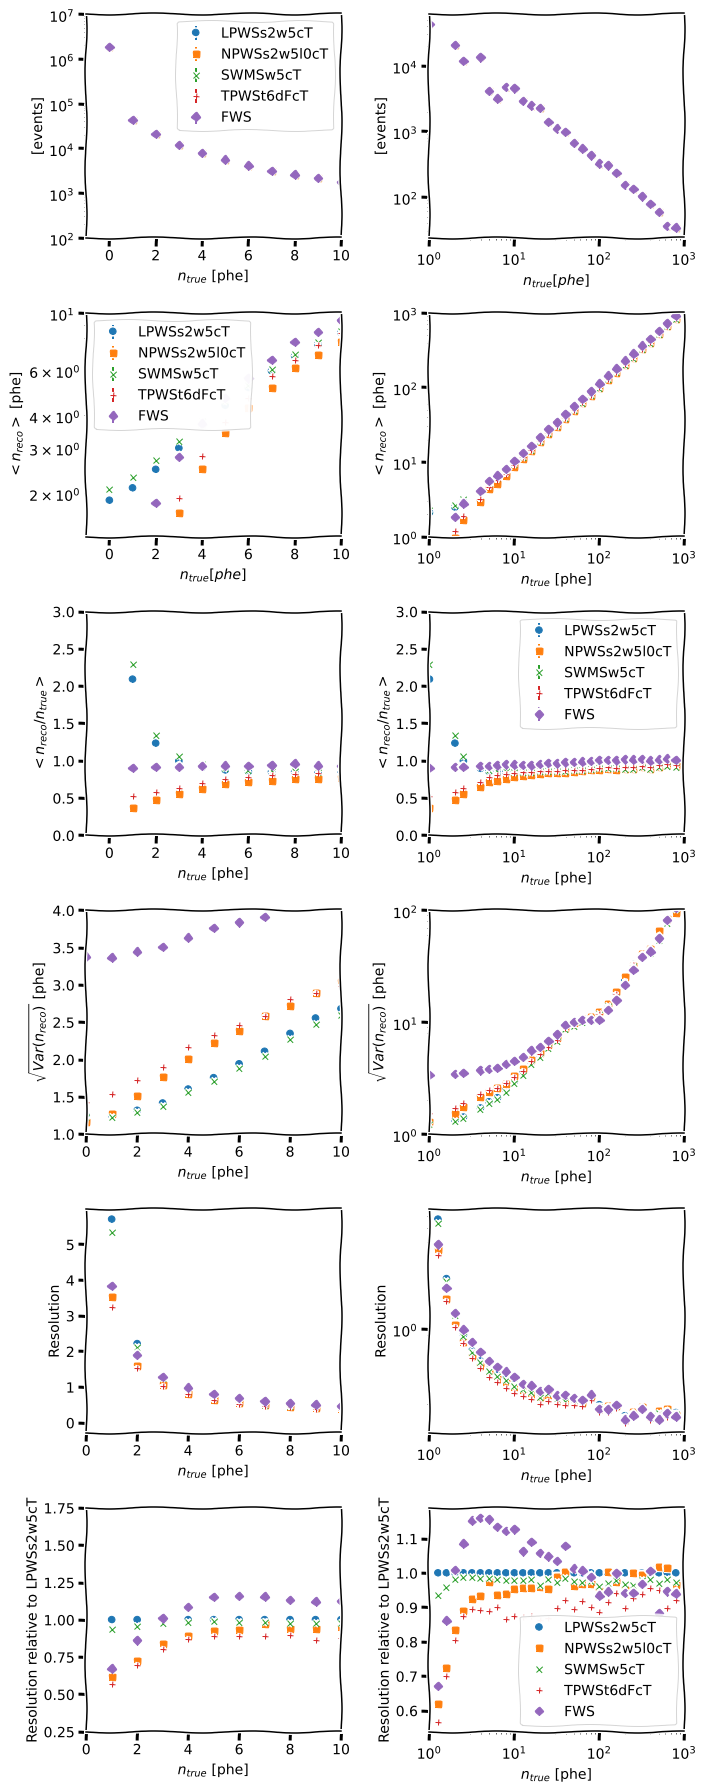

In [15]:
image_extracter_config_benchmark = image_extracter_configs[0]

fig, axes = plt.subplots(6, 2, figsize=(10, 25))
for i, image_extracter_config in enumerate(image_extracter_configs):
    
    iax = 0
    
    # Linear X-axis
    xvalues = (image_extracter_config.reco_stats['mean'][1][:-1])
    
    # Log X-axis    
    logxvalues = (image_extracter_config.reco_stats_log['mean'][1][:-1])
        
    # Event count 
    axes[iax][0].errorbar(xvalues, \
                          image_extracter_config.reco_stats['count'][0], \
                          yerr=np.sqrt(image_extracter_config.reco_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='major', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(100, 1e7)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('[events]')
    #axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          image_extracter_config.reco_stats_log['count'][0], \
                          yerr=np.sqrt(image_extracter_config.reco_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][1].set_ylabel('[events]')
                         
    iax += 1
        
    axes[iax][0].errorbar(xvalues, \
                          image_extracter_config.reco_stats['mean'][0], \
                          yerr=image_extracter_config.reco_stats['std'][0]/np.sqrt(image_extracter_config.reco_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(-1, 10)
    axes[iax][0].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][0].set_ylabel(r'$<n_{reco}>$ [phe]')
    axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          image_extracter_config.reco_stats_log['mean'][0], \
                          yerr=image_extracter_config.reco_stats_log['std'][0]/np.sqrt(image_extracter_config.reco_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}>$ [phe]')
                         
    iax += 1

    axes[iax][0].errorbar(xvalues[1:], \
                          image_extracter_config.reco_frac_stats['mean'][0][1:], \
                          yerr=image_extracter_config.reco_frac_stats['std'][0][1:]/np.sqrt(image_extracter_config.reco_frac_stats['count'][0][1:]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(0, 3)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$<n_{reco}/n_{true}>$')

    # Log X-axis    
    axes[iax][1].errorbar(logxvalues, \
                          image_extracter_config.reco_frac_stats_log['mean'][0], \
                          yerr=image_extracter_config.reco_frac_stats_log['std'][0]/np.sqrt(image_extracter_config.reco_frac_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(0., 3)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}/n_{true}>$')
                         
    iax += 1
    
    axes[iax][0].plot(xvalues, \
                    image_extracter_config.reco_stats['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(1, 4)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')

    axes[iax][1].plot(logxvalues, \
                    image_extracter_config.reco_stats_log['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 100)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')   
                         
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                    image_extracter_config.reco_stats['std'][0][1:] / \
                    (image_extracter_config.reco_stats['mean'][0][1:]-image_extracter_config.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution') #(r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')

    axes[iax][1].plot(logxvalues[1:], \
                    image_extracter_config.reco_stats['std'][0][1:len(logxvalues)] / \
                    (image_extracter_config.reco_stats['mean'][0][1:len(logxvalues)]-image_extracter_config.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution')#r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')
    
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                      image_extracter_config.reco_stats['std'][0][1:] / \
                      image_extracter_config_benchmark.reco_stats['std'][0][1:] / \
                      (image_extracter_config.reco_stats['mean'][0][1:]-image_extracter_config.mean_phe_true0) * \
                      (image_extracter_config_benchmark.reco_stats['mean'][0][1:]-image_extracter_config_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=image_extracter_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(0.25, 1.75)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution relative to {0}'.format(image_extracter_config_benchmark.abbreviation))    

    axes[iax][1].plot(logxvalues[1:], \
                      image_extracter_config.reco_stats['std'][0][1:len(logxvalues)] / \
                      image_extracter_config_benchmark.reco_stats['std'][0][1:len(logxvalues)] / \
                      (image_extracter_config.reco_stats['mean'][0][1:len(logxvalues)]-image_extracter_config.mean_phe_true0) * \
                      (image_extracter_config_benchmark.reco_stats['mean'][0][1:len(logxvalues)]-image_extracter_config_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=image_extracter_config.abbreviation)
    axes[iax][1].set_xscale('log')
    #axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution relative to {0}'.format(image_extracter_config_benchmark.abbreviation))
    
axes[0][0].legend(loc=0)   
axes[2][1].legend(loc=0)
axes[5][1].legend(loc=0)
plt.tight_layout()    

## Distribution for specific-phe-number events

In [16]:
list_true_phes = [0, 3, 6, 10] #List of the true photoelectron numbers to draw the distribution of the reconstructed phe
mask_truephe = {}
true_phe_bins = np.linspace(-10, 30, 201)

for tphe in list_true_phes:
    mask_truephe[tphe] = np.array(true_phe!=tphe)
    logger.debug('True {0}-phe events: {1}'.format(tphe, sum(1-mask_truephe[tphe])))

for i, image_extracter_config in enumerate(image_extracter_configs):
    
    for tphe in list_true_phes:
        image_extracter_config.reco_phe_hists[tphe] = np.histogram(image_extracter_config.dl1_reco_phe, \
                                                                    weights=[float(1-m) for m in mask_truephe[tphe]], \
                                                                  bins=true_phe_bins)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


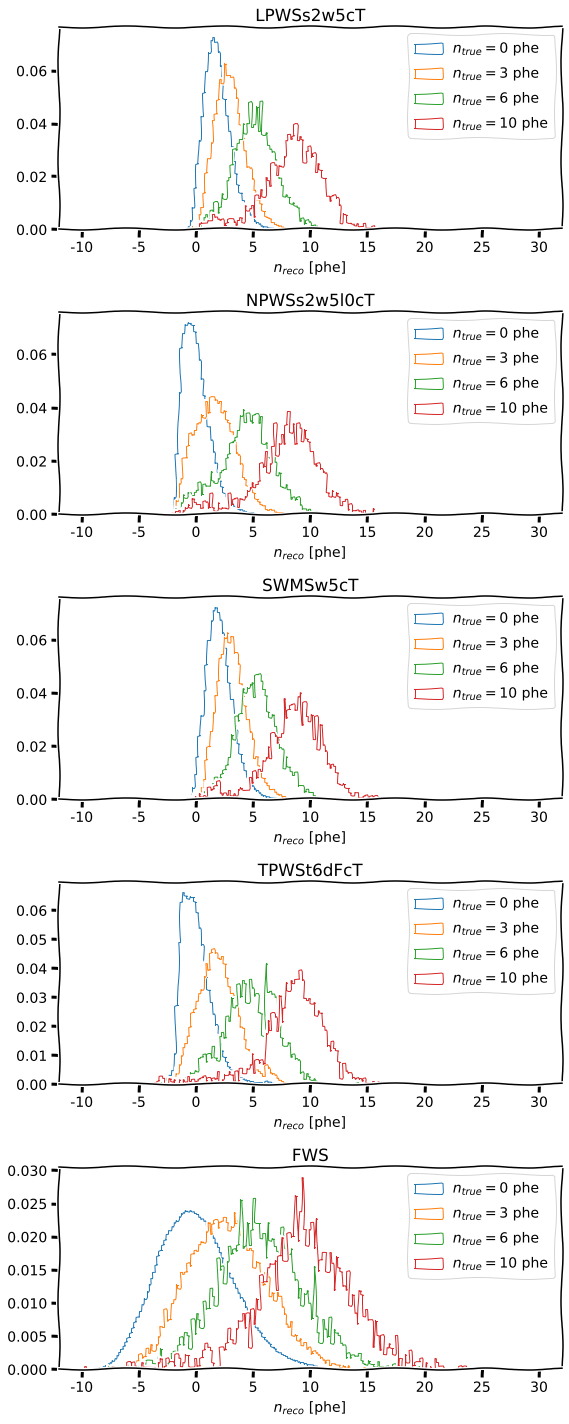

In [17]:
fig, axes = plt.subplots(len(image_extracter_configs), 1, figsize=(8, 4*len(image_extracter_configs)))
for i, image_extracter_config in enumerate(image_extracter_configs):
    for j, tphe in enumerate(list_true_phes):
        axes[i].hist(image_extracter_config.reco_phe_hists[tphe][1][:-1], \
                        image_extracter_config.reco_phe_hists[tphe][1], \
                        weights=image_extracter_config.reco_phe_hists[tphe][0]/sum(image_extracter_config.reco_phe_hists[tphe][0]), \
                        label=r'$n_{{true}}={{{0}}}$ phe'.format(tphe), histtype='step')#, alpha=0.2)
    axes[i].set_title(image_extracter_config.abbreviation)
    axes[i].grid(True, which='major', axis='x')
    axes[i].set_xlabel(r'$n_{reco}$ [phe]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

## ROC Curve

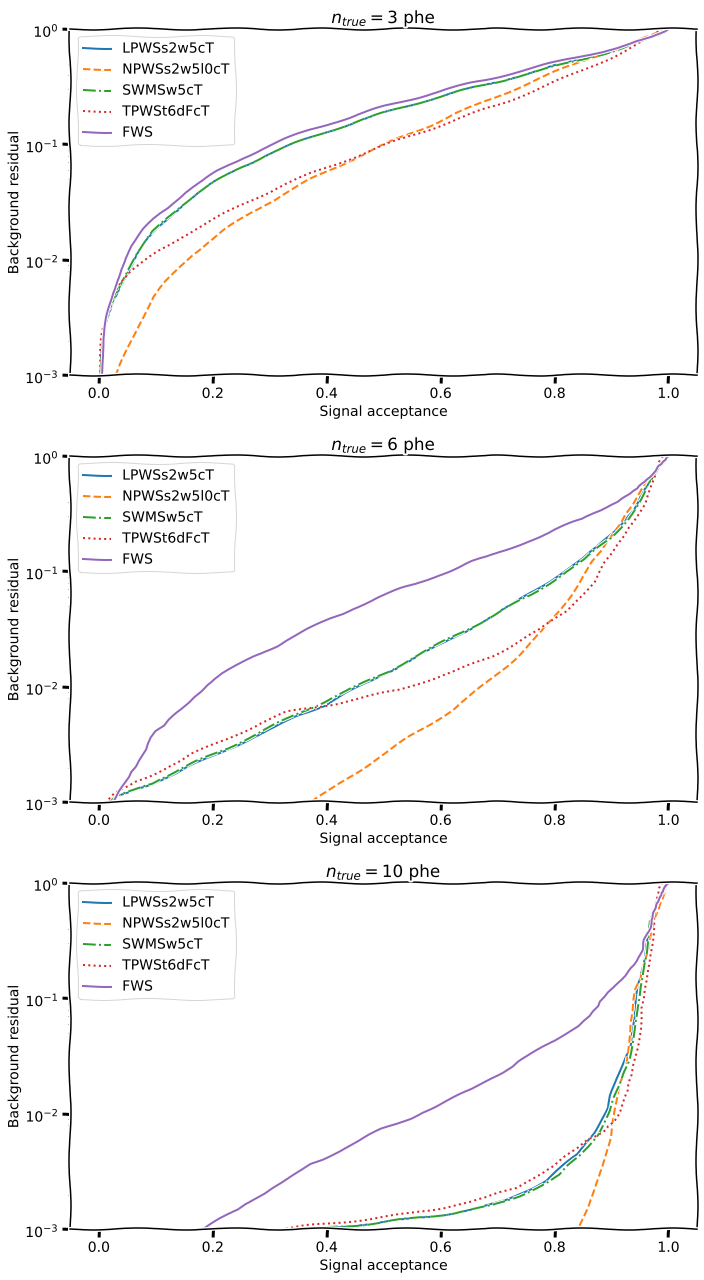

In [18]:
sig_phes = [3, 6, 10]
fig, axes = plt.subplots(len(sig_phes), 1, figsize=(10, 6*len(sig_phes)))

for i, sig_phe in enumerate(sig_phes):
    for j, image_extracter_config in enumerate(image_extracter_configs):
        xvals, yvals = image_extracter_config.get_roc_curve(sig_phe=sig_phe)
        axes[i].plot(xvals, yvals, label=image_extracter_config.abbreviation, ls=LINE_STYLES[j%len(LINE_STYLES)])
    axes[i].set_title(r'$n_{{true}}={0}$ phe'.format(sig_phe))
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel('Signal acceptance')
    axes[i].set_ylabel('Background residual')
    axes[i].legend(loc=0)    
plt.tight_layout()  

# Separation power evaluation
Not working well yet

In [19]:
for i, image_extracter_config in enumerate(image_extracter_configs):
    logger.info(image_extracter_config.config_name)
    image_extracter_config.find_best_separation('error', [0,3])

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue
Best separation gain: 1.000222611027924 by -0.7999999999999989
NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue
Best separation gain: 1.0000162983201415 by -2.1999999999999993
SlidingWindowMaxSum_window_width5_apply_integration_correctiontrue
Best separation gain: 1.0001418714146482 by -0.7999999999999989
TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue
Best separation gain: 1.0000136043096297 by 19.8
FullWaveformSum
Best separation gain: 1.0000212826830621 by -9.4


In [20]:
for i, image_extracter_config in enumerate(image_extracter_configs):
    logger.info(image_extracter_config.config_name)
    image_extracter_config.find_best_separation('error', [0,6])

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue
Best separation gain: 1.221097123709407 by 3.200000000000001
NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue
Best separation gain: 1.2784389098403262 by 2.4000000000000004
SlidingWindowMaxSum_window_width5_apply_integration_correctiontrue
Best separation gain: 1.2261746499669726 by 3.4000000000000004
TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue
Best separation gain: 1.2917870744479316 by 2.200000000000001
FullWaveformSum
Best separation gain: 1.0756431096895616 by 1.8000000000000007


In [21]:
for i, image_extracter_config in enumerate(image_extracter_configs):
    logger.info(image_extracter_config.config_name)
    image_extracter_config.find_best_separation('error', [0,10])

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue
Best separation gain: 1.3951215416210787 by 4.600000000000001
NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue
Best separation gain: 1.4030482660625316 by 3.200000000000001
SlidingWindowMaxSum_window_width5_apply_integration_correctiontrue
Best separation gain: 1.4024359219358262 by 4.600000000000001
TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue
Best separation gain: 1.416829416598955 by 3.8000000000000007
FullWaveformSum
Best separation gain: 1.2938028377523159 by 5.200000000000001
